# Sampling and Monte Carlo Methods

- By Yuan-Sen Ting, April 2025, for ASTRON 5550

In astronomy, we frequently encounter probability distributions that describe physical properties like stellar masses, galaxy luminosities, or measurement uncertainties. While the mathematical forms of these distributions might be known, extracting useful information often requires drawing samples from them. This tutorial explores powerful sampling techniques that form the foundation of modern computational astronomy.

## Prerequisites

Before diving into this tutorial, you should be familiar with:
- Basic concepts of probability theory and statistics
- Fundamentals of calculus, particularly integration
- Basic Python programming skills
- Introductory concepts from the sampling lectures

## What You'll Learn

This tutorial presents three fundamental sampling techniques with astronomical applications:

1. **Inverse CDF Sampling**:
   - Master the technique for generating samples from any distribution with a known and invertible CDF
   - Implement this method for exponential distributions and the Kroupa Initial Mass Function
   - Understand when and why this approach is computationally efficient

2. **Rejection Sampling**:
   - Learn how to sample from complex distributions using simpler proposal distributions
   - Visualize the acceptance/rejection process for stellar mass sampling
   - Analyze the computational efficiency and optimization strategies

3. **Importance Sampling**:
   - Discover how to estimate properties of distributions without direct sampling
   - Calculate expected values using alternative sampling distributions
   - Compare importance sampling with different proposal distributions

Let's begin by setting up our Python environment:

In [1]:
import math
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.stats import uniform, multivariate_normal

%matplotlib inline

# fix a random seed for reproducibility
np.random.seed(42)


## Inverse CDF Sampling: Drawing from Any Distribution

Imagine we need to generate a population of stars with realistic masses, or simulate photon arrival times from a variable source. While programming languages offer built-in functions for uniform random numbers, how do we generate samples from more complex astronomical distributions?

### The Mathematical Foundation

Inverse CDF sampling provides an elegant solution. The key insight is that we can transform uniform random numbers into samples from any distribution with a known cumulative distribution function (CDF).

For a target distribution $p(y)$, the process works in two steps:

1. **Calculate the CDF** $F(y)$ of your target distribution:
   
   $$F(y) = \int_{-\infty}^y p(t) \, dt$$

2. **Apply the inverse transformation** to uniform random numbers:
   
   $$y = F^{-1}(u)$$
   
   where $u \sim \mathcal{U}(0,1)$

This approach works because the CDF transforms any random variable into a uniform random variable on $[0,1]$, and the inverse CDF performs the reverse transformation.

### Example: The Exponential Distribution

Let's start with a simple example: the exponential distribution, which describes phenomena like radioactive decay times or the waiting time between photon arrivals.

The probability density function is:

$$p(y) = 
\begin{cases}
\lambda e^{-\lambda y}, & y \geq 0 \\
0, & y < 0
\end{cases}$$

where $\lambda$ is the rate parameter.

To apply inverse CDF sampling, we need:

1. **The CDF** of the exponential distribution:
   
   $$F(y) = \int_{0}^y \lambda e^{-\lambda t} \, dt = 1 - e^{-\lambda y}$$

2. **The inverse CDF**:
   
   $$F^{-1}(u) = -\frac{1}{\lambda} \ln(1-u)$$

Now we can implement this in Python:

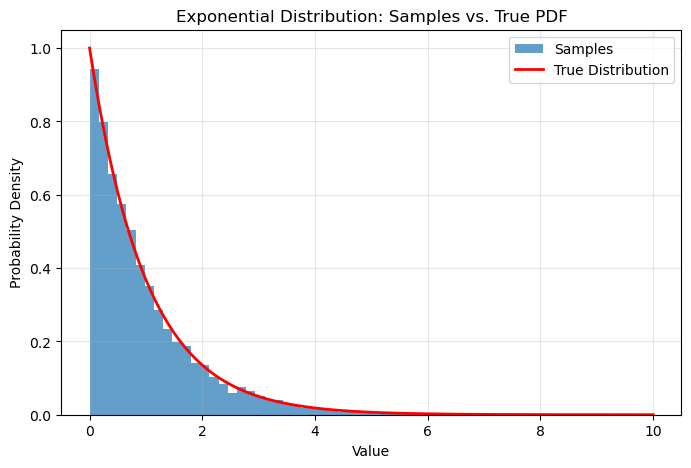

Theoretical mean: 1.0000
Sample mean: 0.9775
Theoretical variance: 1.0000
Sample variance: 0.9494


In [2]:
def sample_exponential(l, size=1):
    """
    Generate samples from an exponential distribution using inverse CDF method.
    
    Parameters:
    -----------
    l : float
        The rate parameter of the exponential distribution.
    size : int
        The number of samples to generate.
    
    Returns:
    --------
    samples : numpy array
        Array of samples from the exponential distribution.
    """
    # Generate uniform random numbers between 0 and 1
    u = np.random.uniform(size=size)
    
    # Apply the inverse CDF transformation
    samples = -(1/l) * np.log(1 - u)
    
    return samples

# Generate 10,000 samples from an exponential distribution with λ = 1
lambda_param = 1
samples = sample_exponential(lambda_param, size=10000)

# Plot the histogram of our samples against the true exponential PDF
plt.figure(figsize=(8, 5))
x = np.linspace(0, 10, 1000)
true_pdf = lambda_param * np.exp(-lambda_param * x)

plt.hist(samples, bins=50, density=True, alpha=0.7, label='Samples')
plt.plot(x, true_pdf, 'r-', linewidth=2, label='True Distribution')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Exponential Distribution: Samples vs. True PDF')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate some statistics to verify our sampling
print(f"Theoretical mean: {1/lambda_param:.4f}")
print(f"Sample mean: {np.mean(samples):.4f}")
print(f"Theoretical variance: {1/lambda_param**2:.4f}")
print(f"Sample variance: {np.var(samples):.4f}")

### Astronomical Application: The Kroupa Initial Mass Function

Now let's apply inverse CDF sampling to a more complex astronomical problem: generating a realistic population of stellar masses using the Kroupa Initial Mass Function (IMF).

#### The Astrophysical Context

The Initial Mass Function is one of the most fundamental concepts in stellar astronomy, describing how stellar masses are distributed when stars are born. Its shape influences nearly everything in galactic evolution:

- The luminosity and color of galaxies
- Chemical enrichment of the interstellar medium
- Rates of supernovae and other stellar endpoints
- Dynamical evolution of star clusters

The Kroupa IMF is a widely-used piecewise power-law model based on observations of star-forming regions in our galaxy.

#### Mathematical Formulation

The Kroupa IMF is defined as:

$$ p(m) = 
    \begin{cases} 
      K_1 m^{-0.3} & 0.01 \leq m < 0.08 \\
      K_2 m^{-1.3} & 0.08 \leq m < 0.5 \\
      K_3 m^{-2.3} & 0.5 \leq m \leq 1 
   \end{cases}
$$

where the constants $K_1$, $K_2$, and $K_3$ ensure the function is continuous and properly normalized.

#### Step 1: Determine Normalization Constants

To find our normalization constants, we need to:
1. Ensure continuity at the boundaries (0.08 and 0.5)
2. Ensure the entire function integrates to 1 over [0.01, 1]

First, let's establish continuity:

At $m = 0.08$: $K_1 \times 0.08^{-0.3} = K_2 \times 0.08^{-1.3}$, thus $K_2 = K_1 \times 0.08$

At $m = 0.5$: $K_2 \times 0.5^{-1.3} = K_3 \times 0.5^{-2.3}$, thus $K_3 = K_2 \times 0.5$

Now, let's calculate the integral values for each segment and solve for $K_1$:

In [3]:
# Calculate integrals for each segment of the IMF
int_segment1 = scipy.integrate.quad(lambda x: x**(-0.3), 0.01, 0.08)[0]
int_segment2 = scipy.integrate.quad(lambda x: x**(-1.3), 0.08, 0.5)[0]
int_segment3 = scipy.integrate.quad(lambda x: x**(-2.3), 0.5, 1.0)[0]

print(f"Integral of segment 1 (m^-0.3 from 0.01 to 0.08): {int_segment1:.4f}")
print(f"Integral of segment 2 (m^-1.3 from 0.08 to 0.5): {int_segment2:.4f}")
print(f"Integral of segment 3 (m^-2.3 from 0.5 to 1.0): {int_segment3:.4f}")

# Using the continuity relations, express K2 and K3 in terms of K1
# K2 = K1 * 0.08
# K3 = K2 * 0.5 = K1 * 0.08 * 0.5

# The total integral should equal 1
# K1 * int_segment1 + K2 * int_segment2 + K3 * int_segment3 = 1

# Substitute the expressions for K2 and K3
# K1 * int_segment1 + K1 * 0.08 * int_segment2 + K1 * 0.08 * 0.5 * int_segment3 = 1

# Solve for K1
K1 = 1 / (int_segment1 + 0.08 * int_segment2 + 0.08 * 0.5 * int_segment3)
K2 = K1 * 0.08
K3 = K2 * 0.5

print(f"K1 = {K1:.4f}")
print(f"K2 = {K2:.4f}")
print(f"K3 = {K3:.4f}")

Integral of segment 1 (m^-0.3 from 0.01 to 0.08): 0.1869
Integral of segment 2 (m^-1.3 from 0.08 to 0.5): 3.0075
Integral of segment 3 (m^-2.3 from 0.5 to 1.0): 1.1248
K1 = 2.1162
K2 = 0.1693
K3 = 0.0846


#### Step 2: Deriving the Inverse CDF

To apply inverse CDF sampling, we need to:
1. Find the CDF of the Kroupa IMF
2. Calculate the proportion of probability in each segment
3. Derive the inverse CDF for each segment

For the Kroupa IMF, the CDF in each segment is:

**Segment 1** ($0.01 \leq m < 0.08$):
$$ F_1(m) = K_1 \int_{0.01}^{m} t^{-0.3} dt = K_1 \left[ \frac{t^{0.7}}{0.7} \right]_{0.01}^{m} $$

**Segment 2** ($0.08 \leq m < 0.5$):
$$ F_2(m) = F_1(0.08) + K_2 \int_{0.08}^{m} t^{-1.3} dt = F_1(0.08) + K_2 \left[ \frac{t^{-0.3}}{-0.3} \right]_{0.08}^{m} $$

**Segment 3** ($0.5 \leq m \leq 1$):
$$ F_3(m) = F_2(0.5) + K_3 \int_{0.5}^{m} t^{-2.3} dt = F_2(0.5) + K_3 \left[ \frac{t^{-1.3}}{-1.3} \right]_{0.5}^{m} $$

Let's define the total probability in each segment as:
- $A$: Probability mass in segment 1 = $F_1(0.08)$
- $B$: Probability mass in segment 2 = $F_2(0.5) - F_1(0.08)$
- $C$: Probability mass in segment 3 = $F_3(1) - F_2(0.5) = 1 - F_2(0.5)$

This categorizes our uniform random variable, $u$, as:
- If $0 \leq u < A$: Use the inverse of $F_1$
- If $A \leq u < A+B$: Use the inverse of $F_2$
- If $A+B \leq u \leq 1$: Use the inverse of $F_3$

The inverse functions for each segment are:

1. **For $0 \leq u < A$**:
   $$ m(u) = \left( \frac{0.7u}{K_1} + 0.01^{0.7} \right)^{1/0.7} $$

2. **For $A \leq u < A+B$**:
   $$ m(u) = \left( \frac{-0.3(u-A)}{K_2} + 0.08^{-0.3} \right)^{-1/0.3} $$

3. **For $A+B \leq u \leq 1$**:
   $$ m(u) = \left( \frac{-1.3(u-A-B)}{K_3} + 0.5^{-1.3} \right)^{-1/1.3} $$

Now let's implement the inverse CDF sampling for the Kroupa IMF:

Total probability (A + B + C): 0.999460


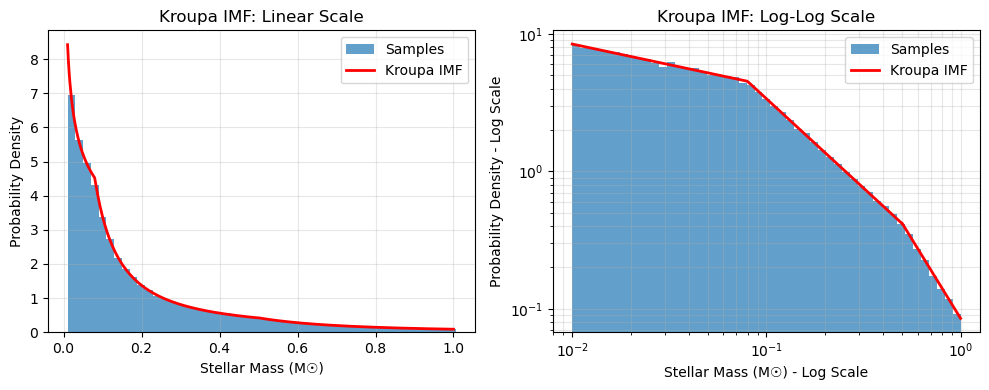

Mean stellar mass: 0.1895 M☉
Median stellar mass: 0.1089 M☉
Fraction of stars below 0.08 M☉ (brown dwarfs): 0.3945
Fraction of stars above 0.5 M☉: 0.0944


In [4]:
def sample_kroupa_imf(size=1):
    """
    Generate stellar masses following the Kroupa IMF using inverse CDF sampling.
    
    Parameters:
    -----------
    size : int
        Number of stellar masses to generate.
        
    Returns:
    --------
    masses : numpy array
        Array of stellar masses following the Kroupa IMF.
    """
    # Normalization constants
    K1 = 2.116
    K2 = 0.169
    K3 = 0.085
    
    # Generate uniform random numbers
    u = np.random.uniform(size=size)
    
    # Initialize array for masses
    masses = np.zeros(size)
    
    # Calculate probability mass in each segment
    A = K1 * (0.08**0.7 - 0.01**0.7) / 0.7
    B = K2 * (0.5**(-0.3) - 0.08**(-0.3)) / (-0.3)
    C = K3 * (1**(-1.3) - 0.5**(-1.3)) / (-1.3)
    
    # Verify our normalization (A + B + C should ≈ 1)
    print(f"Total probability (A + B + C): {A + B + C:.6f}")
    
    # Define masks for each segment
    mask1 = (u < A)
    mask2 = (u >= A) & (u < A+B)
    mask3 = (u >= A+B)
    
    # Apply the inverse CDF for each segment
    masses[mask1] = (0.7 * u[mask1] / K1 + 0.01**0.7)**(1/0.7)
    masses[mask2] = (-0.3 * (u[mask2] - A) / K2 + 0.08**(-0.3))**(-1/0.3)
    masses[mask3] = (-1.3 * (u[mask3] - A - B) / K3 + 0.5**(-1.3))**(-1/1.3)
    
    return masses

# Generate 100,000 stellar masses
stellar_masses = sample_kroupa_imf(size=100000)

# Define the Kroupa IMF for plotting
def kroupa_imf(m):
    """Evaluate the Kroupa IMF at mass m."""
    K1 = 2.116
    K2 = 0.169
    K3 = 0.085

    if m < 0.01:
        return 0
    elif m < 0.08:
        return K1 * m**(-0.3)
    elif m < 0.5:
        return K2 * m**(-1.3)
    elif m <= 1.0:
        return K3 * m**(-2.3)
    else:
        return 0

# Create plots to visualize the results
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Regular scale plot
ax = axes[0]
ax.hist(stellar_masses, bins=50, density=True, alpha=0.7, label="Samples")
mass_range = np.linspace(0.01, 1, 500)
pdf_values = np.vectorize(kroupa_imf)(mass_range)
ax.plot(mass_range, pdf_values, 'r-', linewidth=2, label="Kroupa IMF")
ax.set_xlabel("Stellar Mass (M☉)")
ax.set_ylabel("Probability Density")
ax.set_title("Kroupa IMF: Linear Scale")
ax.legend()
ax.grid(True, alpha=0.3)

# Log-log scale plot
ax = axes[1]
ax.hist(stellar_masses, bins=np.logspace(np.log10(0.01), np.log10(1.0), 50), 
        density=True, alpha=0.7, label="Samples")
ax.plot(mass_range, pdf_values, 'r-', linewidth=2, label="Kroupa IMF")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Stellar Mass (M☉) - Log Scale")
ax.set_ylabel("Probability Density - Log Scale")
ax.set_title("Kroupa IMF: Log-Log Scale")
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Calculate statistics about our stellar population
print(f"Mean stellar mass: {np.mean(stellar_masses):.4f} M☉")
print(f"Median stellar mass: {np.median(stellar_masses):.4f} M☉")
print(f"Fraction of stars below 0.08 M☉ (brown dwarfs): {np.mean(stellar_masses < 0.08):.4f}")
print(f"Fraction of stars above 0.5 M☉: {np.mean(stellar_masses > 0.5):.4f}")

## Rejection Sampling: Handling Complex Distributions

While inverse CDF sampling is elegant and efficient, it requires an analytical form of the CDF and its inverse. For many astronomical distributions, these functions might be unavailable or too complex to derive. Rejection sampling offers an alternative approach that can handle virtually any distribution with a known probability density function (PDF).

### The Mathematical Principle

Rejection sampling enables us to draw samples from a target distribution $p(x)$ using a simpler proposal distribution $q(x)$ that we already know how to sample from. The key requirements are:

1. We must be able to evaluate $p(x)$ up to a normalizing constant
2. We need a proposal distribution $q(x)$ that is easy to sample from
3. We need a scaling constant $M$ such that $M \cdot q(x) \geq p(x)$ for all $x$

The algorithm works as follows:

1. Draw a sample $x_0$ from the proposal distribution $q(x)$
2. Generate a uniform random number $u_0$ between 0 and $M \cdot q(x_0)$
3. Accept $x_0$ if $u_0 \leq p(x_0)$; otherwise reject and try again

The power of this method is its flexibility—it works for almost any target distribution, regardless of its complexity.

### Astronomical Application: Sampling from the Kroupa IMF

Let's implement rejection sampling for the Kroupa IMF using an exponential distribution as our proposal. The exponential distribution provides a good balance—it's easy to sample from and can be scaled to envelop our target IMF with a reasonable acceptance rate.

Acceptance rate: 0.4538
Total samples evaluated: 11018


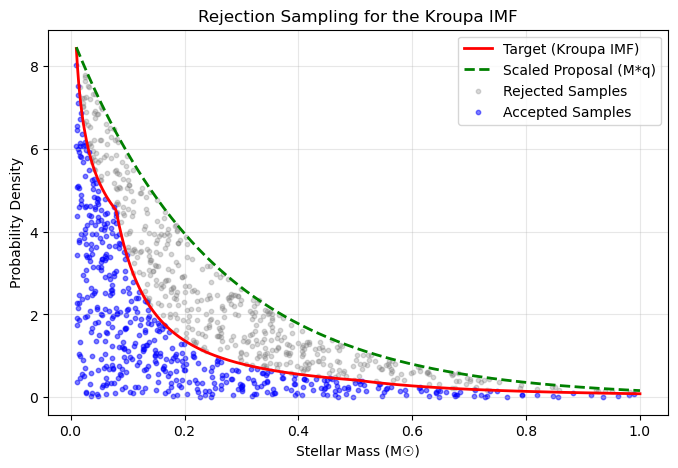

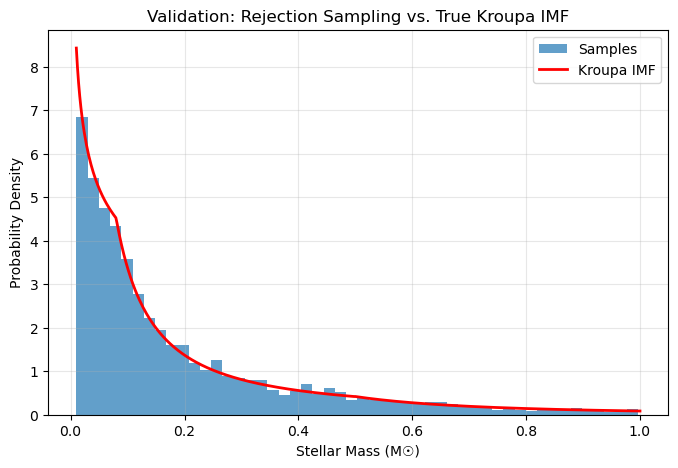

In [5]:
def sample_exponential(lambda_param, size=1):
    """
    Sample from the exponential distribution using the inverse CDF method.
    """
    u = np.random.uniform(size=size)
    return -(1 / lambda_param) * np.log(1 - u)

def rejection_sample_kroupa(num_samples=10000, visualize=True):
    """
    Generate samples from the Kroupa IMF using rejection sampling.
    
    Parameters:
    -----------
    num_samples : int
        Number of samples to generate
    visualize : bool
        Whether to visualize the sampling process
    
    Returns:
    --------
    accepted_samples : numpy array
        Array of accepted samples following the Kroupa IMF
    """
    # Parameters for our sampling
    lambda_param = 4.0  # Rate parameter for exponential proposal
    M = 2.2  # Scaling factor to ensure M*q(x) ≥ p(x)
    
    # Initialize storage for our samples
    accepted_samples = []
    accepted_heights = []
    rejected_samples = []
    rejected_heights = []
    
    # Counter for tracking efficiency
    total_trials = 0
    
    # Function to evaluate the proposal distribution q(x)
    def q(x):
        return lambda_param * np.exp(-lambda_param * x)
    
    # Continue until we have enough samples
    while len(accepted_samples) < num_samples:
        total_trials += 1
        
        # Step 1: Draw from proposal distribution q(x)
        x = sample_exponential(lambda_param, 1)[0]
        
        # Only consider samples in our valid range [0.01, 1.0]
        if x < 0.01 or x > 1.0:
            continue
        
        # Step 2: Calculate the height of the scaled proposal
        qx = q(x)
        # Step 3: Draw uniform random number
        u = np.random.uniform(0, M * qx)
        
        # Step 4: Accept/reject based on target density
        px = kroupa_imf(x)
        if u <= px:
            accepted_samples.append(x)
            accepted_heights.append(u)
        else:
            rejected_samples.append(x)
            rejected_heights.append(u)
    
    # Calculate acceptance rate
    acceptance_rate = len(accepted_samples) / total_trials
    print(f"Acceptance rate: {acceptance_rate:.4f}")
    print(f"Total samples evaluated: {total_trials}")
    
    if visualize:
        # Prepare data for visualization
        accepted_samples = np.array(accepted_samples)
        accepted_heights = np.array(accepted_heights)
        rejected_samples = np.array(rejected_samples)
        rejected_heights = np.array(rejected_heights)
        
        # Visualize the rejection sampling process
        plt.figure(figsize=(8, 5))
        
        # Plot the target and proposal distributions
        x_range = np.linspace(0.01, 1.0, 500)
        p_values = np.vectorize(kroupa_imf)(x_range)
        q_values = M * np.vectorize(q)(x_range)
        
        plt.plot(x_range, p_values, 'r-', linewidth=2, label='Target (Kroupa IMF)')
        plt.plot(x_range, q_values, 'g--', linewidth=2, label='Scaled Proposal (M*q)')
        
        # Plot accepted and rejected samples
        plt.scatter(rejected_samples[:500], rejected_heights[:500], s=10, alpha=0.3, 
                   c='gray', label='Rejected Samples')
        plt.scatter(accepted_samples[:500], accepted_heights[:500], s=10, alpha=0.5,
                   c='blue', label='Accepted Samples')
        
        plt.xlabel('Stellar Mass (M☉)')
        plt.ylabel('Probability Density')
        plt.title('Rejection Sampling for the Kroupa IMF')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Validate our sampling by comparing histogram with the true IMF
        plt.figure(figsize=(8, 5))
        plt.hist(accepted_samples, bins=50, density=True, alpha=0.7, label='Samples')
        plt.plot(x_range, p_values, 'r-', linewidth=2, label='Kroupa IMF')
        plt.xlabel('Stellar Mass (M☉)')
        plt.ylabel('Probability Density')
        plt.title('Validation: Rejection Sampling vs. True Kroupa IMF')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    return np.array(accepted_samples)

# Generate samples using rejection sampling
kroupa_samples_rejection = rejection_sample_kroupa(num_samples=5000, visualize=True)

## Importance Sampling: Efficiently Estimating Properties

So far we've focused on generating samples from distributions. But often in astronomy, our real goal is to calculate an expectation or average property of a distribution, like the mean stellar mass in a population or the average luminosity of a source.

Importance sampling offers a powerful approach that can calculate these properties more efficiently than direct sampling. Instead of generating samples from our target distribution, we sample from an alternative "proposal" distribution and adjust the weights of our samples to account for the differences.

### The Mathematical Foundation

In mathematical terms, if we want to calculate the expectation of a function $f(x)$ with respect to a probability distribution $p(x)$, we can write:

$$\mathbb{E}_{p(x)}[f(x)] = \int f(x) p(x) dx$$

Using importance sampling, we rewrite this as:

$$\mathbb{E}_{p(x)}[f(x)] = \int f(x) \frac{p(x)}{q(x)} q(x) dx = \mathbb{E}_{q(x)}\left[f(x) \frac{p(x)}{q(x)}\right]$$

where $q(x)$ is our proposal distribution. This allows us to estimate the expectation using:

$$\mathbb{E}_{p(x)}[f(x)] \approx \frac{1}{N} \sum_{i=1}^{N} f(x_i) \frac{p(x_i)}{q(x_i)}$$

where $x_i$ are samples drawn from $q(x)$.

### Importance Sampling with Unnormalized Distributions

In practice, we often work with unnormalized distributions $\tilde{p}(x)$ and $\tilde{q}(x)$, where:

$$p(x) = \frac{\tilde{p}(x)}{\int \tilde{p}(x) dx} \quad \text{and} \quad q(x) = \frac{\tilde{q}(x)}{\int \tilde{q}(x) dx}$$

In this case, our importance sampling estimator becomes:

$$\mathbb{E}_{p(x)}[f(x)] \approx \frac{\sum_{i=1}^{N} f(x_i) w(x_i)}{\sum_{i=1}^{N} w(x_i)}$$

where $w(x_i) = \frac{\tilde{p}(x_i)}{\tilde{q}(x_i)}$ are the importance weights.

### Astronomical Application: Mean Stellar Mass in the Kroupa IMF

Let's apply importance sampling to calculate the mean stellar mass according to the Kroupa IMF. We'll try two different proposal distributions to see how the choice affects our estimates:

1. An exponential distribution, which follows the general shape of the IMF
2. A uniform distribution, which is simpler but less aligned with the IMF's shape

In [ ]:
# fix a random seed for reproducibility
np.random.seed(52)

def importance_sampling_mean(num_samples, proposal='exponential'):
    """
    Estimate the mean stellar mass of the Kroupa IMF using importance sampling.
    
    Parameters:
    -----------
    num_samples : int
        Number of samples to use
    proposal : str
        Type of proposal distribution ('exponential' or 'uniform')
    
    Returns:
    --------
    mean_estimate : float
        Estimated mean stellar mass
    """
    if proposal == 'exponential':
        # Use exponential distribution as proposal
        lambda_val = 5.0
        
        # Generate samples from the proposal distribution
        samples = sample_exponential(lambda_val, num_samples)
        
        # Keep only samples in our valid range [0.01, 1.0]
        valid_mask = (samples >= 0.01) & (samples <= 1.0)
        samples = samples[valid_mask]
        
        # Compute the proposal density at each sample
        q_values = lambda_val * np.exp(-lambda_val * samples)
        
    elif proposal == 'uniform':
        # Use uniform distribution as proposal
        samples = np.random.uniform(0.01, 1.0, num_samples)
        
        # Density of the uniform proposal is constant
        q_values = np.ones_like(samples) / (1.0 - 0.01)
    
    else:
        raise ValueError("Proposal must be 'exponential' or 'uniform'")
    
    # Compute the target density (Kroupa IMF) at each sample
    p_values = np.vectorize(kroupa_imf)(samples)
    
    # Compute importance weights
    weights = p_values / q_values
    
    # Our function f(x) is just x (the mass) since we're computing the mean
    weighted_masses = samples * weights
    
    # Calculate the normalized weighted average
    mean_estimate = np.sum(weighted_masses) / np.sum(weights)
    
    return mean_estimate

# Compare with exact value calculated by numerical integration
def exact_mean_stellar_mass():
    """Calculate the exact mean stellar mass using numerical integration."""
    def integrand(m):
        return m * kroupa_imf(m)
    
    # Integrate m * p(m) from 0.01 to 1.0
    mean, _ = scipy.integrate.quad(integrand, 0.01, 1.0)
    return mean

# Calculate using both proposal distributions
exact_mean = exact_mean_stellar_mass()
print(f"Exact mean stellar mass: {exact_mean:.6f} M☉")

# Run importance sampling with different numbers of samples for both proposals
sample_sizes = np.logspace(2, 5, 10).astype(int)
exp_means = []
unif_means = []

for n in sample_sizes:
    exp_mean = importance_sampling_mean(n, proposal='exponential')
    unif_mean = importance_sampling_mean(n, proposal='uniform')
    exp_means.append(exp_mean)
    unif_means.append(unif_mean)
    print(f"N={n}: Exponential = {exp_mean:.6f}, Uniform = {unif_mean:.6f}")

# Plot convergence behavior
plt.figure(figsize=(10, 6))
plt.semilogx(sample_sizes, exp_means, 'o-', label='Exponential Proposal')
plt.semilogx(sample_sizes, unif_means, 's-', label='Uniform Proposal')
plt.axhline(y=exact_mean, color='r', linestyle='-', label='Exact Value')
plt.xlabel('Number of Samples')
plt.ylabel('Estimated Mean Stellar Mass (M☉)')
plt.title('Convergence of Importance Sampling Estimates')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Plot the distribution of importance weights to understand efficiency
plt.figure(figsize=(12, 5))

# Generate samples for analysis
n_analysis = 10000
exp_samples = sample_exponential(5.0, n_analysis)
exp_valid = (exp_samples >= 0.01) & (exp_samples <= 1.0)
exp_samples = exp_samples[exp_valid]
exp_weights = np.vectorize(kroupa_imf)(exp_samples) / (5.0 * np.exp(-5.0 * exp_samples))

unif_samples = np.random.uniform(0.01, 1.0, n_analysis)
unif_weights = np.vectorize(kroupa_imf)(unif_samples) * (1.0 - 0.01)

# Plot weight distributions
plt.subplot(1, 2, 1)
plt.hist(exp_weights, bins=50, alpha=0.7, density=True)
plt.title('Exponential Proposal: Weight Distribution')
plt.xlabel('Importance Weight')
plt.ylabel('Density')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(unif_weights, bins=50, alpha=0.7, density=True)
plt.title('Uniform Proposal: Weight Distribution')
plt.xlabel('Importance Weight')
plt.ylabel('Density')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Deep Dive: Exponential vs. Uniform Proposals in Importance Sampling

We've seen how importance sampling allows us to estimate properties of a distribution without directly sampling from it. The choice of proposal distribution is critical to the method's efficiency, so let's analyze the differences between our exponential and uniform proposals.

#### Theoretical Considerations

The optimal proposal distribution for importance sampling would be proportional to $|f(x)p(x)|$, where $f(x)$ is the function whose expectation we're calculating and $p(x)$ is our target distribution. In our case, we're calculating the mean stellar mass, so $f(x) = x$ and our ideal proposal would be proportional to $x \times \text{Kroupa IMF}(x)$.

Let's compare our two choices:

1. **Exponential Proposal**: 
   - Decreases with increasing mass, roughly following the general shape of the IMF
   - Puts more weight on lower masses where the IMF has higher probability
   - Parameter $\lambda = 5$ was chosen to provide reasonable coverage

2. **Uniform Proposal**:
   - Assigns equal probability across all masses
   - Simpler to implement and understand
   - May waste samples on regions with very low probability in the target


#### Weight Distribution Analysis

The efficiency of importance sampling is reflected in the distribution of weights. Ideally, weights should be relatively uniform—highly variable weights indicate that some samples are much more important than others, reducing the effective sample size.

- **Exponential Proposal**: Shows a more concentrated weight distribution, indicating more consistent sample importance
- **Uniform Proposal**: Has a wider spread of weights, with more very small and very large values

The effective sample size (ESS) can be approximated as:

$$\text{ESS} = \frac{(\sum_{i=1}^N w_i)^2}{\sum_{i=1}^N w_i^2}$$

A higher ESS indicates more efficient sampling. For the same number of drawn samples, the exponential proposal **typically** yields a higher ESS than the uniform proposal.

#### When Differences Would Be More Pronounced

The advantages of a well-chosen proposal distribution become much more significant when:

1. The target distribution has heavy tails or isolated modes
2. The function $f(x)$ amplifies certain regions of the distribution
3. The dimension of the sampling space increases

For example, if we were estimating the mean of stellar luminosity (which scales approximately as $M^{3.5}$), the importance of sampling the higher-mass end of the IMF would increase dramatically, and a uniform proposal would become much less efficient than one that places more emphasis on higher masses.

#### Practical Recommendation

For the Kroupa IMF and mean mass calculation:
- If simplicity is valued, the uniform proposal is adequate
- For slightly better efficiency, particularly with fewer samples, the exponential proposal is preferable
- For optimal performance, a proposal specifically tailored to $x \times \text{Kroupa IMF}(x)$ would be best

This case study illustrates an important principle in computational statistics: the best choice depends not just on theoretical optimality, but on the practical balance between implementation simplicity, computational efficiency, and the specific properties of the problem at hand.

## Summary: The Art and Science of Sampling

In this tutorial, we've explored three powerful sampling techniques through the lens of stellar astronomy. Each method offers unique advantages for different scenarios:

### Comparing Sampling Methods

1. **Inverse CDF Sampling**
   - **Strengths**: Directly generates independent samples from the target distribution with no wasted computations
   - **Limitations**: Requires an analytical form of the CDF and its inverse, which may be unavailable or difficult to derive
   - **Best for**: Distributions with known, invertible CDFs when you need many independent samples

2. **Rejection Sampling**
   - **Strengths**: Works for virtually any distribution with a known PDF, even complex multimodal distributions
   - **Limitations**: Can be computationally inefficient if the proposal distribution doesn't match the target well
   - **Best for**: Complex distributions without analytical CDFs when computational efficiency isn't the primary concern

3. **Importance Sampling** 
   - **Strengths**: Efficiently estimates expectations without having to sample directly from the target distribution
   - **Limitations**: Doesn't generate samples from the target distribution; requires careful choice of proposal distribution to avoid high variance
   - **Best for**: Estimating specific properties (like expectations) rather than generating representative samples

### Choice of Method

When deciding which sampling method to use, consider:

1. **What information do you need?** 
   - To generate a representative population → Inverse CDF or rejection sampling
   - To estimate specific properties → Importance sampling

2. **What do you know about the distribution?**
   - Analytical CDF and inverse → Inverse CDF sampling
   - PDF only → Rejection or importance sampling

3. **Computational constraints**
   - Limited computational resources → Importance sampling or well-tuned rejection sampling
   - Need for highly accurate samples → Inverse CDF when possible

### Looking Forward

While the sampling methods we've explored are powerful for many astronomical applications, they face significant challenges in high-dimensional spaces:

- **Inverse CDF Sampling**: Becomes impractical in multiple dimensions
- **Rejection Sampling**: Suffers from the "curse of dimensionality" with exponentially decreasing acceptance rates
- **Importance Sampling**: Struggles to find efficient proposal distributions in high dimensions

These limitations are critical for modern astronomical problems that often involve sampling from complex, high-dimensional distributions.

In our next lecture, we'll introduce Markov Chain Monte Carlo (MCMC) methods that overcome these dimensional challenges. MCMC techniques form the backbone of modern Bayesian inference in astronomy, enabling us to efficiently sample high-dimensional parameter spaces that would be intractable with the methods presented here.

The fundamental concepts you've learned in this tutorial provide the necessary foundation for understanding these more advanced sampling techniques.